> The cube SN1, SN2 and SN3 of NGC2903 would be good.
> It would be more convenient than the video is interactive, but ... in a notebook to see would be perfect. 
> It would be convenient that the video is centered around a large line for each filter, 
> Eg Halpha to SN3, OIII5007 for SN2, OII3727 to SN1. 
> 
> It can extract the wavelengths in cm-1 and header find the approximate position of the corresponding line + - the velocity of the object. 
> The videos could use 10 images for SN1 and SN2 (which are more basic resolution) and 30 images to SN3. 
> 
> There are several example of the ORCS site: http://celeste.phy.ulaval.ca/orcs-doc/examples.html

> Seb: Its probably a good idea to use hdf5! Plus its more common outside of astronomy anyways

TODO: H \alpha instead of Halpha
TODO: Coloured image?
TODO: Show selection of xrii, yrii, etc

# Exploring Data Cubes with SITELLE

In this notebook, we will explore data cubes from [SITELLE](http://www.cfht.hawaii.edu/Instruments/Sitelle/), an optical imaging spectrometer at the CFHT. We will query and collect data using tools provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ) then make an interactive widget to explore different energy bands in the M33 galaxy.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Imaging Results](#5.-Imaging-Results)
    * [5.1 Deep frame preview](#5.1-Deep-frame-preview)
    * [5.2 Extract spectrum](#5.2-Extract-spectrum)
    * [5.3 Characteristic lines [OII]3727, [OIII]5007, Halpha](#5.3-Characteristic-lines-[OII]3727,-[OIII]5007,-Halpha)
* [6. Cube Widget](#6.-Cube-Widget)
    
## 1. Introduction

This tutorial will use packages such as astropy, astroquery, ORCS, matplotlib, and ipywidgets, to make an interactive widget that shows the M33 galaxy in different filters throughout energies centered around different characterisic lines, namely [OII]3727, [OIII]5007, and Halpha.

### SITELLE
#TODO

## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 


## 3. Querying

### HDF5 Data Cubes
The SITELLE data cubes will be in HDF5 file format, which is best suited to store large and complex data. The [ORCS package](https://github.com/thomasorb/orcs) is an analysis engine specifically tailored to handle SITELLE data cubes, so that is what will be used in this tutorial. More information can be found in the [ORCS documentation](https://orcs.readthedocs.io/en/latest/).

In [1]:
%matplotlib inline
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, PowerNorm

import orb
from orcs.core import HDFCube


Let's define what kind of objects we want to retreive from the CADC database. The objects should have the following traits:
- Instrument name is 'SITELLE'
- Collection is 'CFHT'
- Data is of type 'cube'
- Target name contains 'M33'
- [Energy filter](http://www.cfht.hawaii.edu/Instruments/Sitelle/SITELLE_filters.php) is one of 'SN1', 'SN2', or 'SN3'
- Quality is not junk!

Now that we have the list of query parameters, we can build a query in ADQL.

In [2]:
from astroquery.cadc import Cadc

cadc = Cadc()

query = '''SELECT * FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE  ( Observation.instrument_name = 'SITELLE' 
AND Observation.collection = 'CFHT' 
AND Plane.dataProductType = 'cube' 
AND LOWER(Observation.target_name) LIKE '%m33_field7%'
AND Plane.energy_bandpassName IN ('SN1', 'SN2', 'SN3') 
AND  ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )'''
#
#COORD1(CENTROID(Plane.position_bounds)) AS "RA", 
#COORD2(CENTROID(Plane.position_bounds)) AS "Dec."

#TODO: Ask about target_name?
#AND LOWER(Observation.target_name) LIKE '%m33_field7%'
#AND Observation.proposal_project = 'SIGNALS'

job = cadc.run_query(query, 'sync')
results = job.get_results()

cols = ['caomPublisherID', 'productID', 'target_name', '__RA_', '__Dec._', 
        'energy_bandpassName', 'calibrationLevel', 'dataRelease', 
        'dataProductType', 'energy_emBand', 'sequenceNumber', 'collection',
        'type', 'intent',  'proposal_project', 'proposal_title', 'instrument_name']
results[cols].show_in_notebook()

idx,caomPublisherID,productID,target_name,__RA_,__Dec._,energy_bandpassName,calibrationLevel,dataRelease,dataProductType,energy_emBand,sequenceNumber,collection,type,intent,proposal_project,proposal_title,instrument_name
0,ivo://cadc.nrc.ca/CFHT?2326978p/2326978p,2326978p,m33_field7,23.21647680283865,30.58053107891658,SN1,2,2018-10-12T00:00:00.000,cube,Optical,2326978,CFHT,OBJECT,science,SIGNALS,The SIGNALS Project,SITELLE
1,ivo://cadc.nrc.ca/CFHT?2325242p/2325242p,2325242p,m33_field7,23.216472645228794,30.580531098309184,SN2,2,2018-10-12T00:00:00.000,cube,Optical,2325242,CFHT,OBJECT,science,SIGNALS,The SIGNALS Project,SITELLE
2,ivo://cadc.nrc.ca/CFHT?2309128p/2309128p,2309128p,m33_field7,23.216699483472592,30.58053285862901,SN3,2,2018-10-12T00:00:00.000,cube,Optical,2309128,CFHT,OBJECT,science,SIGNALS,The SIGNALS Project,SITELLE


## 4. Fetching Data
Now that we have the table of results, we can use the `get_data_urls` function from the CADC astroquery module to grab all associated URLs, and only select the `.hdf5` access urls. We will also build the filename from the target name, product ID, and energy filter name. 

In [3]:
import re

results_list = []
for idx in range(len(results)):
    urls = cadc.get_data_urls(results[idx:idx+1], include_auxiliaries=True)
    hdf5_url = next((url.encode('utf-8') for url in urls if '.hdf5' in url), None)
    if hdf5_url:
        fname = '{}.{}.{}.hdf5'.format(results[idx]['target_name'], 
                                       results[idx]['productID'], 
                                       results[idx]['energy_bandpassName']) 
        results_list.append({'fname': fname, 'url': hdf5_url})

results_list

[{'fname': 'm33_field7.2326978p.SN1.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2326978z.hdf5?RUNID=jatqq9l5mu1ifq9l'},
 {'fname': 'm33_field7.2325242p.SN2.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2325242z.hdf5?RUNID=vqxdczn7k9seamfc'},
 {'fname': 'm33_field7.2309128p.SN3.hdf5',
  'url': 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2309128z.hdf5?RUNID=dbwvym1m19diwwee'}]

Using the requests package, we will use the access url and write the data under the filename generated in the previous code block.

In [22]:
# import requests

# for product in results_list:
#     resp = requests.get(product['url'], stream=True)
#     if resp.status_code == 200:
#         with open(product['fname'], 'wb') as f:
#             for chunk in resp.iter_content(1024):
#                 f.write(chunk)


Now we open the files and then access and summarize the information.

In [23]:
# Load the cubes 
cubes = [HDFCube(result['fname']) for result in results_list]
lines = ['[OII]3727', '[OIII]5007', 'Halpha']
bands = ['SN1', 'SN2', 'SN3']

# The coordinates of the HII region and the sky region
xrhii, yrhii = (690, 270)
xsky, ysky = (1405, 780)
aperture = 3  # Aperture for the spectrum integration (circle)
data_list = []

for cube, line, band in zip(cubes, lines, bands):
    axis, spectrum = cube.extract_spectrum(xrhii, yrhii, aperture, silent=True)
    axis2, sky = cube.extract_spectrum(xsky, ysky, aperture, silent=True)
    spectrum = spectrum - sky
    line_idx = np.where(spectrum == max(spectrum))[0][0]

    data_list.append({'cube': cube, 'line': line, 'band': band,
                      'line_idx': line_idx, 'spectrum': spectrum, 
                      'sky': sky, 'axis': axis})
    

INFO| Data shape : (2048, 2064, 171)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber
INFO| Data shape : (2048, 2064, 220)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber
INFO| Data shape : (2048, 2064, 842)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber


## 5. Imaging Results
Now that we have the data downloaded, we can analyze and display the data.

### 5.1 Deep frame preview
The [deep frame](http://celeste.phy.ulaval.ca/orcs-doc/examples/deep_wcs.html?highlight=deep%20frame) is the mean of the interferometric images along the scan axis.  

<IPython.core.display.Javascript object>


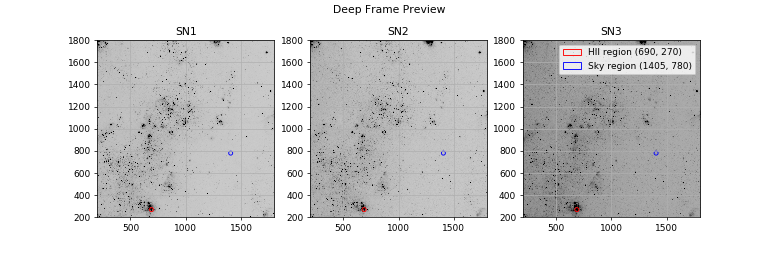

In [24]:
#TODO: Do different colours?? rgb image???
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), frameon=False)

hii_circle = lambda : plt.Circle((xrhii, yrhii), aperture*6, ec='red', 
                                 fill=False, label='HII region ({}, {})'.format(xrhii, yrhii))
sky_circle = lambda : plt.Circle((xsky, ysky), aperture*6, ec='blue', 
                                 fill=False, label='Sky region ({}, {})'.format(xsky, ysky))

for ax, data in zip(axes, data_list):
    deep_frame = data['cube'].get_deep_frame()
    band = data['band']
    
    ax.imshow(deep_frame.T,
               origin='bottom-left',
               vmin=np.nanpercentile(deep_frame, 0.05),
               vmax=np.nanpercentile(deep_frame, 99.5),
               cmap='gray_r')

    ax.add_artist(hii_circle())
    ax.add_artist(sky_circle())
    
    ax.set_title(band)
    ax.set_xlim((200, 1800))
    ax.set_ylim((200, 1800))
    ax.grid()
    
plt.legend(handles=[hii_circle(), sky_circle()])
fig.suptitle('Deep Frame Preview');


Since the energy filter is SN1, we want to look at OII3727 energy bands. For SN2, we will look at OIII5007, and for SN3, we will look at Halpha.

### 5.2 Extract spectrum

Here we extract the spectrum of an [HII region](https://en.wikipedia.org/wiki/H_II_region) and the sky to find Halpha.

<IPython.core.display.Javascript object>


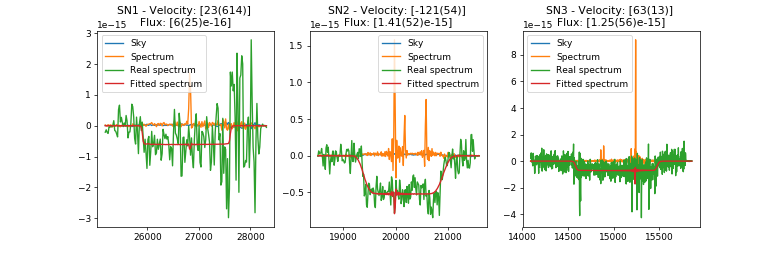

INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.025 s]                                   
 [==========] [100%] [completed in 0.126 s]                                   


INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.031 s]                                   
 [==========] [100%] [completed in 0.133 s]                                   


INFO| Number of integrated pixels: 29


 [==========] [100%] [completed in 0.028 s]                                   
 [==========] [100%] [completed in 0.133 s]                                   


In [25]:
# pos_def: Definition of the position (i.e. wavenumber) parameter of each
#    line e.g. may be ‘free’, ‘fixed’ or a group key (e.g. ‘1’, ‘a’ etc.), 
#    set to ‘free’ by default
# pos_cov: velocity guess of the grouped lines in km/s. the covariation 
#    operation is Doppler shifting.
# https://github.com/thomasorb/orcs/blob/master/orcs/core.py#L1172
# https://github.com/thomasorb/orcs/blob/master/orcs/utils.py#L41
# https://github.com/thomasorb/orb/blob/master/orb/fit.py#L2544

def get_fit_lines_in_spectrum(cube,
                              sky,
                              xrhii=932,
                              yrhii=1025,
                              aperture=3,
                              line='[OII]3727'):
    # What is fit axis
    fit_axis, fit_spectrum, fit_res = cube.fit_lines_in_spectrum(
        xrhii, yrhii, aperture, [line], subtract_spectrum=sky, fmodel='sinc')
    return fit_axis, fit_spectrum, fit_res


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), frameon=False)

for ax, data in zip(axes, data_list):
    fit_axis, fit_spectrum, fit_res = get_fit_lines_in_spectrum(data['cube'],
                                                                data['sky'],
                                                                line=data['line'])
#     ax.plot(fit_axis, data['sky'], label='Sky')
#     ax.plot(fit_axis, data['spectrum'], label='Spectrum')
    ax.plot(fit_axis, fit_spectrum, label='Real spectrum')
    ax.plot(fit_axis, fit_res['fitted_vector'], label='Fitted spectrum')
    ax.legend()

    ax.set_title('{} - Velocity: {} \nFlux: {}'.format(
        data['band'], fit_res['velocity_gvar'], fit_res['flux_gvar']))

fig.suptitle('Spectrum', y=1.1);

### 5.3 Characteristic lines [OII]3727, [OIII]5007, Halpha

WARNING| /opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "

WARNING| /opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)



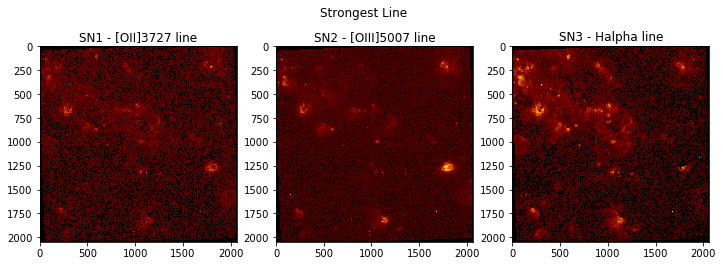

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), frameon=False)

for ax, data in zip(axes, data_list):
    cube = data['cube'] 
    image_data = cube.get_data_frame(data['line_idx'], silent=True)
    image_data[np.where(np.isfinite(image_data) == False)] = 1e-20
    image_data = np.arcsinh(image_data)

    mi = -1e-19
    ma = 8e-16
    #ax.clim(mi,ma)
    gamma = 1./3.5
    ax.imshow(image_data, cmap='afmhot', norm=PowerNorm(gamma=gamma))
    ax.set_title('{} - {} line'.format(data['band'], data['line'] ))
    
fig.suptitle('Strongest Line');

## 6. Cube Widget

In [10]:
# Get dataframes for 20 frames before and after halpha
def get_image_list(cube, line_idx, num_frames=10):
    i_min, i_max = (line_idx - num_frames/2, line_idx + num_frames/2)
    img_list = []
    for i in range(i_min, i_max): 
        img = cube.get_data_frame(i, silent=True) # some array of images
        img[np.where(np.isfinite(img) == False)] = 1e-20
        img = np.arcsinh(img)
        img_list.append(img)
    return img_list

for data in data_list:
    data['img_list'] = get_image_list(data['cube'], data['line_idx'])

<IPython.core.display.Javascript object>


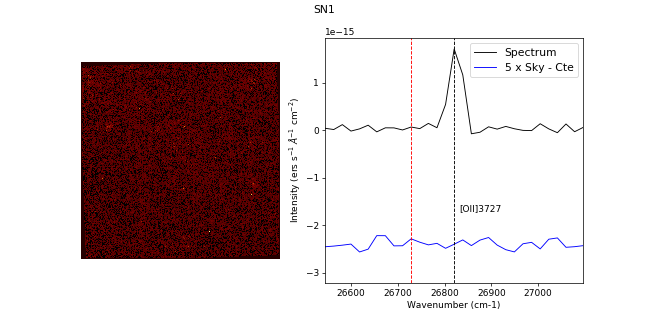

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J1dhdmVudW1iZXI6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwMHB4JyksIG9wdGlvbnM9KCgnMjbigKY=


In [21]:
%matplotlib notebook

%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import Layout, interact, widgets

def plot_widget(data, num_frames=10):
    mi, ma= -1e-19, 8e-16
    
    img_list, spectrum, sky, axis, line_idx, band = (data['img_list'], data['spectrum'], 
            data['sky'], data['axis'], data['line_idx'], data['band'])
        
    i_min, i_max = (line_idx - num_frames / 2, line_idx + num_frames / 2)
    
    fig, (ax0, ax1) = plt.subplots(nrows=1,
                                   ncols=2,
                                   figsize=(10, 5),
                                   gridspec_kw={'width_ratios': [1, 1.3]},
                                   frameon=False)
    ax1.plot(axis, spectrum, c='k', linewidth=1, label='Spectrum')
    ax1.plot(axis,
             5 * sky - 2.5e-15,
             c='blue',
             linewidth=1,
             label='5 x Sky - Cte')

    xlim = (axis[i_min - num_frames], axis[i_max + num_frames])
    ax1.set_xlim(xlim)
    ax1.set_xlabel('Wavenumber (cm-1)')
    ax1.set_ylabel('Intensity (ers s$^{-1}$ $\AA$$^{-1}$ cm$^{-2}$)')
    ax1.axvline(x=axis[line_idx], c='black', linestyle='--', linewidth=1)
    ax1.annotate(data['line'], (axis[line_idx]+(xlim[1] - xlim[0])*0.02, -1.7e-15 ))
    
    ax1.legend(fontsize=12, loc=1)
    ax0.axis('off')
    
    fig.suptitle(band)

    #     ax1.annotate('$\mathrm{H}$'+r'$\alpha$',xy=(0.7,0.8),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('$\mathrm{[NII]\lambda6548}$',xy=(0.72,0.35),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('$\mathrm{[NII]\lambda6583}$',xy=(0.55,0.41),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('$\mathrm{HeI\lambda6678}$',xy=(0.22,0.3),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('$\mathrm{[SII]\lambda6716}$',xy=(0.07,0.41),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('$\mathrm{[SII]\lambda6731}$',xy=(0.01,0.37),xycoords='axes fraction',\
    #                 fontsize=12.0, color='k')
    #     ax1.annotate('-----------------------Sky\'s OH lines-----------------------',\
    # xy=(0.48,0.07),xycoords='axes fraction',\
    #                 fontsize=12.0, color='b')

    def plot_image(wavenumber):
        idx = np.where(axis == wavenumber)[0][0]
        img = img_list[idx - i_min]
        ax0.imshow(img,
                   cmap='afmhot',
                   norm=PowerNorm(gamma=gamma),
                   clim=[mi, ma])
        if len(ax1.lines) > 3:
            ax1.lines.remove(ax1.lines[-1])
        ax1.axvline(x=axis[idx], color='r', linestyle='--', linewidth=1)
        plt.show()

    interact(plot_image,
             wavenumber=widgets.SelectionSlider(options=[
                 ('{:0.0f} (cm-1)'.format(wavenumber), wavenumber)
                 for wavenumber in axis[i_min:i_max]
             ],
                 description='Wavenumber:',
                 layout={'width': '700px'},
               style={
                    'description_width':
                    'initial'}))
    plt.show()

data = data_list[0]

plot_widget(data_list[0])

<IPython.core.display.Javascript object>


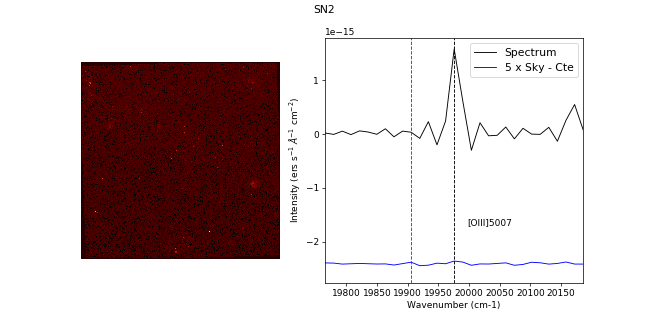

(19765.43523924672, 20186.27488238185)
21.041982156756603


aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J1dhdmVudW1iZXI6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwMHB4JyksIG9wdGlvbnM9KCgnMTnigKY=


In [13]:
plot_widget(data_list[1])

<IPython.core.display.Javascript object>


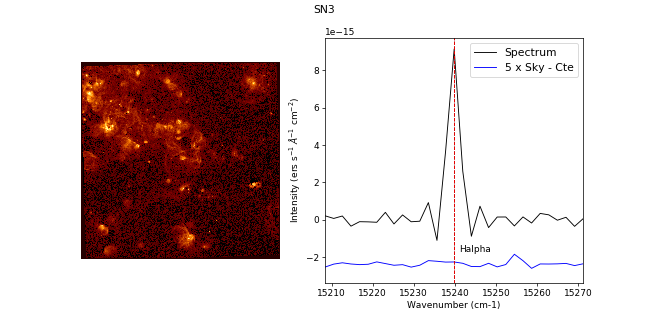

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J1dhdmVudW1iZXI6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwMHB4JyksIG9wdGlvbnM9KCgnMTXigKY=


In [20]:
plot_widget(data_list[2])